# Add the Annotated Time in Bed to the Dataset

In [1]:
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

BEDTIME_FILEPATH = os.path.join(os.sep, 'home', 'data', 'BEDTIME_TU7.hdf5')
ANNOTATED_FILEPATH = os.path.join(os.sep, 'home', 'data', 'ANNOTATED_BEDTIME_TU7.hdf5')

## Load the annotation data

In [2]:
df = pd.read_pickle("results_combined.pkl")
all_annotated_subjects = list(df["subject"])
df = df.loc[df["IoU"] > .9, :]
annotated_subjects = list(df["subject"])

print("{} subjects with annotated Actiwave data".format(len(all_annotated_subjects)))
print("{} subjects annotated with IoU over .9".format(len(annotated_subjects)))

557 subjects with annotated Actiwave data
478 subjects annotated with IoU over .9


## Load the list of all subjects

In [3]:
with h5py.File(BEDTIME_FILEPATH, 'r') as hdf5_file:
    subjects = list(hdf5_file.keys())
    n_subjects = len(subjects)

subjects = [subject for subject in subjects if subject in annotated_subjects]

print("{} subjects in with data from both devices".format(n_subjects))
print("{} of annotated subjects did not had valid data or worn both devices".format(len(annotated_subjects) - len(subjects)))
print("{} subjects with annotations to process".format(len(subjects)))

582 subjects in with data from both devices
33 of annotated subjects did not had valid data or worn both devices
445 subjects with annotations to process


## Calculate start and end time as the intersection of the two annotator's ratings

In [4]:
df.loc[:,"start"] = df[["start_marc", "start_shaheen"]].max(axis=1) 
df.loc[:,"end"] = df[["end_marc", "end_shaheen"]].min(axis=1)

## Process the annotated subjects

In this section, we should loop over the subjects and save annotated data and subjects to a new hdf5 database

In [5]:
# Create new empty h5 file
with h5py.File(ANNOTATED_FILEPATH, 'w') as hdf5_file:
    hdf5_file.attrs["readme"] = "This dataset contains the raw acceleration data from \
                                 ActiGraph devices in the X, Y and Z column as well as \
                                 the time the subject spent in bed based on annotated \
                                 data the ActiWave device in the 'Annotated Time in Bed' \
                                 column. Time information is stored in the Time column."
    
for subject in tqdm(subjects):
    tmp = pd.read_hdf(BEDTIME_FILEPATH, key=subject)

    start = df.loc[df["subject"] == subject, "start"].values[0]
    end = df.loc[df["subject"] == subject, "end"].values[0]

    tmp.loc[:, "Annotated Time in Bed"] = False
    tmp.loc[(tmp["Time"] > start) & (tmp["Time"] < end), "Annotated Time in Bed"] = True
    
    tmp = tmp.loc[:, ["Time", "X", "Y", "Z", "Annotated Time in Bed"]]
    
    tmp.to_hdf(ANNOTATED_FILEPATH, key=subject)

  0%|          | 0/445 [00:00<?, ?it/s]

## Visualize the annotated subjects

In [6]:
def process_subject(subject):
    tmp = pd.read_hdf(BEDTIME_FILEPATH, key=subject)

    start = df.loc[df["subject"] == subject, "start"].values[0]
    end = df.loc[df["subject"] == subject, "end"].values[0]

    tmp.loc[:, "Annotated Time in Bed"] = False
    tmp.loc[(tmp["Time"] > start) & (tmp["Time"] < end), "Annotated Time in Bed"] = True
    
    res = np.full(3600*48, -1.)

    idx = tmp.loc[:, "Time"] - np.array(tmp.loc[0,"Time"], dtype="datetime64[D]")
    
    if tmp.loc[0,"Time"] == tmp.loc[0,"Time"].normalize():
        idx += np.timedelta64(1, 'D')    
    
    res[idx.astype(int)//1e9] = 1
    
    res[idx[tmp["Annotated Time in Bed"]].astype(int)//1e9] = 2
    
    return pd.DataFrame({subject: res})

with Pool(200) as p:
    data_overview = pd.concat(p.map(process_subject, subjects), axis=1, ignore_index=True)

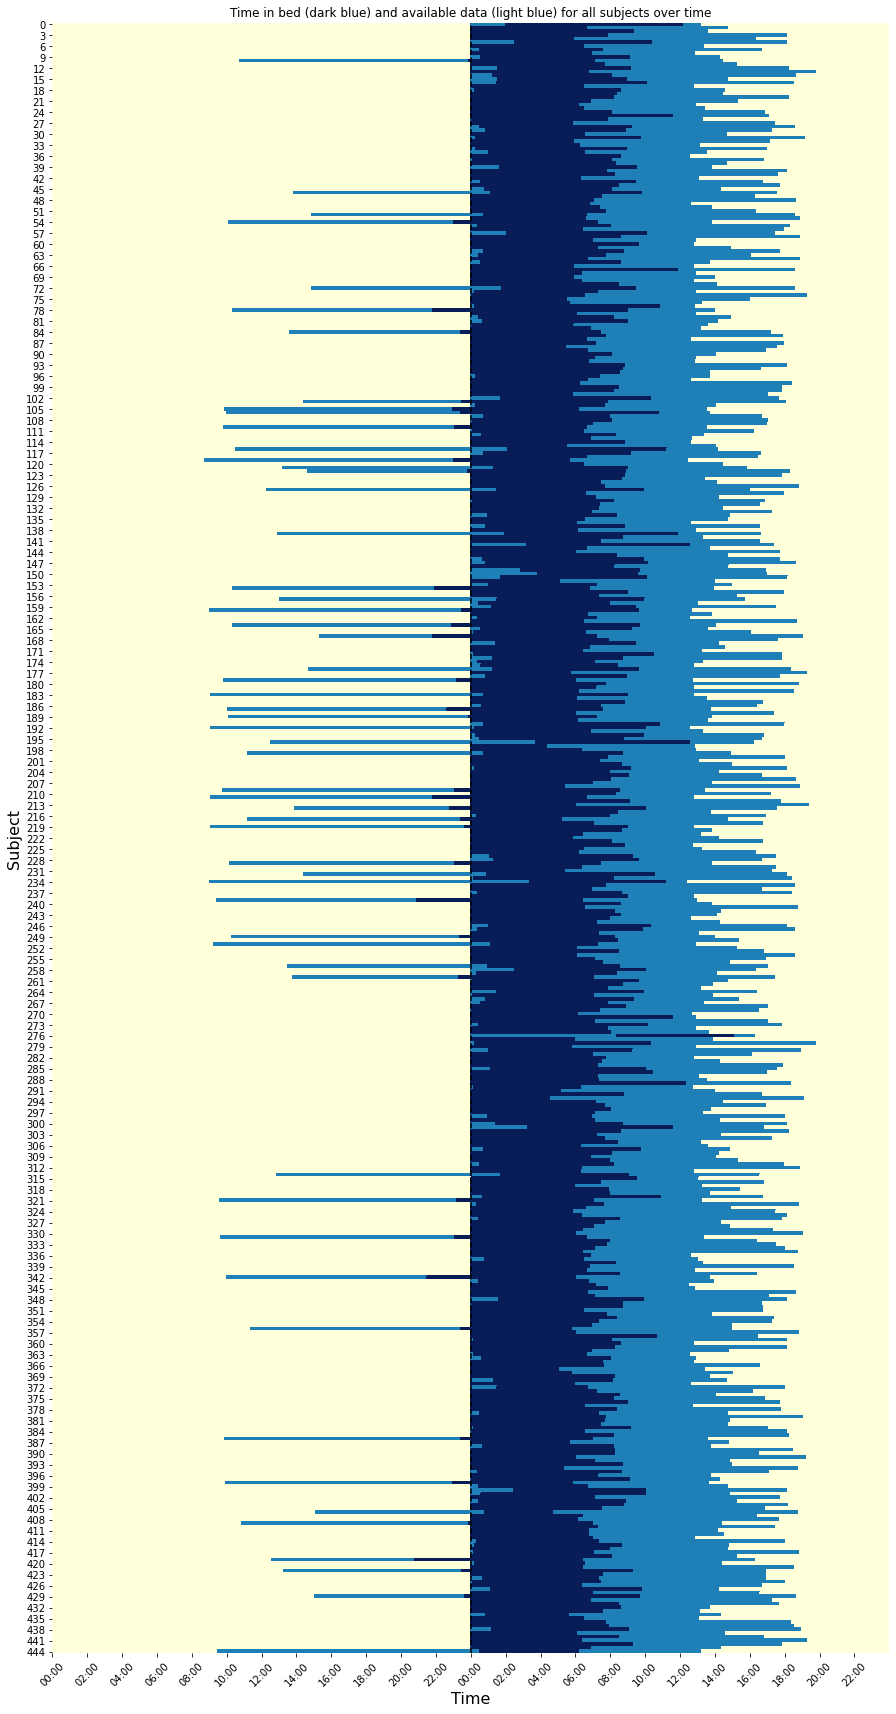

In [7]:
plt.figure(figsize=(15,30))

ax = sns.heatmap(data_overview[::60].T.values, cmap="YlGnBu", cbar=False)

ax.axvline(60*24, zorder=3, ls="--", c="black")

ax.set_title('Time in bed (dark blue) and available data (light blue) for all subjects over time')
ax.set_xlabel('Time', size=16)   
ax.set_ylabel('Subject', size=16)   

n_hours = 48
ticks, labels = zip(*[(ii * 60 * 2, "{:02d}:00".format((ii * 2) % 24)) for ii in range(24)])

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45)

#ax.set_yticks([])
#ax.set_yticklabels([])

print('')

## Summary

In [8]:
print("{} subjects were processed and stored to {}".format(len(subjects), ANNOTATED_FILEPATH))

avg = str((df["end"] - df["start"]).mean())[7:15]
std = str((df["end"] - df["start"]).std())[7:15]
print("Average annotated time in bed: {} +/- {}".format(avg, std))

445 subjects were processed and stored to /home/data/ANNOTATED_BEDTIME_TU7.hdf5
Average annotated time in bed: 08:17:44 +/- 01:24:43
